In [2]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Mon Dec 10 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.0-7-amd64
machine    : x86_64
processor  : 
CPU cores  : 12
interpreter: 64bit


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
eeg_signals = np.transpose(data.values)

Opening raw data file /home/kovar/thesis_project/data/processed/1a.fif...
This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-3-1d393a8a483f>:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


tau=2


/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/d2.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Compute the Takens-Theiler maximum likelihood estimator.


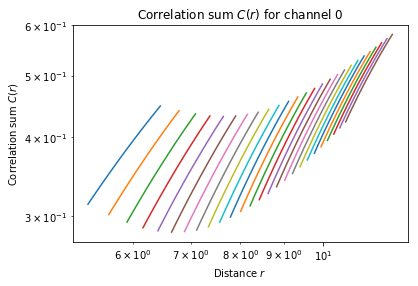

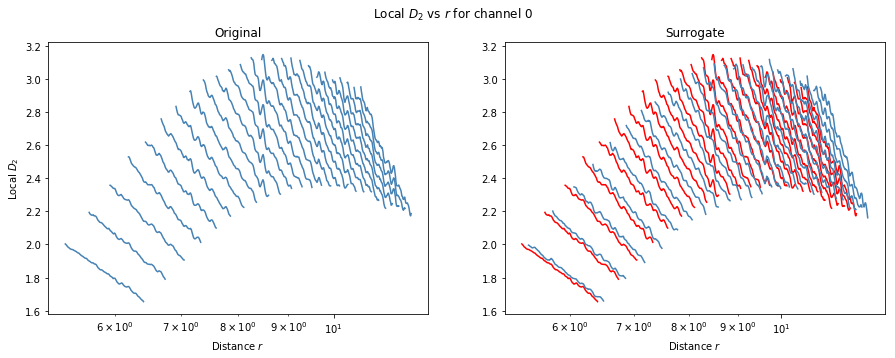

tau=3


Process ForkPoolWorker-492:
Process ForkPoolWorker-491:
Process ForkPoolWorker-484:
Traceback (most recent call last):
Process ForkPoolWorker-487:
Process ForkPoolWorker-486:
Process ForkPoolWorker-488:
Process ForkPoolWorker-493:
Process ForkPoolWorker-490:
Traceback (most recent call last):
Process ForkPoolWorker-489:
Process ForkPoolWorker-494:
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/h

KeyboardInterrupt: 

  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/numpy/lib/histograms.py", line 787, in histogram
    sa = np.sort(a[i:i+BLOCK])
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/d2.py", line 103, in c2
    c += np.histogram(dists, bins=bins)[0]
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/numpy/lib/histograms.py", line 787, in histogram
    sa = np.sort(a[i:i+BLOCK])
KeyboardInterrupt
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/d2.py", line 102, in c2
    dists = distance.cdist([y[i]], y[i + wind

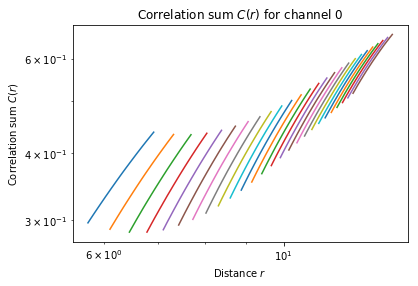

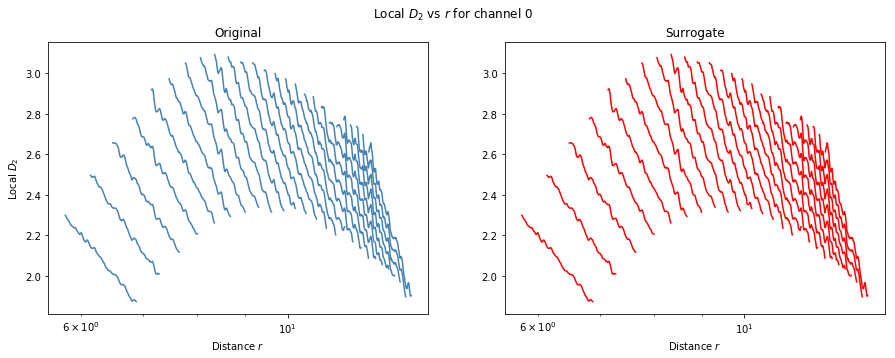

Process ForkPoolWorker-511:
Process ForkPoolWorker-520:
Process ForkPoolWorker-509:
Process ForkPoolWorker-498:
Process ForkPoolWorker-508:
Process ForkPoolWorker-519:
Process ForkPoolWorker-518:
Process ForkPoolWorker-501:
Process ForkPoolWorker-504:
Process ForkPoolWorker-496:
Process ForkPoolWorker-514:
Traceback (most recent call last):
Process ForkPoolWorker-499:
Process ForkPoolWorker-500:
Process ForkPoolWorker-517:
Process ForkPoolWorker-512:
Process ForkPoolWorker-510:
Process ForkPoolWorker-497:
Process ForkPoolWorker-516:
Process ForkPoolWorker-513:
Process ForkPoolWorker-503:
Process ForkPoolWorker-495:
Process ForkPoolWorker-505:
Process ForkPoolWorker-502:
Traceback (most recent call last):
Process ForkPoolWorker-507:
Process ForkPoolWorker-515:
Process ForkPoolWorker-506:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call

  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/hom

KeyboardInterrupt
KeyboardInterrupt
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get(

In [12]:
from lib.nolitsa.nolitsa import d2, surrogates, utils
from lib.nolds.nolds.measures import corr_dim
import matplotlib.pyplot as plt

chan_data = eeg_signals[chan_num][:8128]
# for chan_num, chan_data in enumerate(eeg_signals):
for tau in np.arange(2, 8):
    print(f'tau={tau}')
    surr_data, i, e = surrogates.iaaft(chan_data)
    dim = np.arange(5, 30+1)
    
    y = utils.reconstruct(chan_data, dim[0], tau)
    
    rcs = d2.c2_embed(chan_data, tau=tau, dim=dim, window=50, metric='chebyshev', r=100)

    plt.figure(1)
    plt.title(f'Correlation sum $C(r)$ for channel {chan_num}')
    plt.xlabel(r'Distance $r$')
    plt.ylabel(r'Correlation sum $C(r)$')

    for r, c in rcs:
        # plt.plot(np.log(r), np.log(c))
        plt.loglog(r, c)
        p = np.polyfit(np.log(r), np.log(c), 1)
        # plt.loglog(r, np.polyval(p, np.log(r)))
        
    plt.figure(2, figsize=(15,5))
    plt.suptitle(f'Local $D_2$ vs $r$ for channel {chan_num}')
    plt.subplot(121)
    plt.title('Original')
    plt.xlabel(r'Distance $r$')
    plt.ylabel(r'Local $D_2$')

    for r, c in rcs:
        plt.semilogx(r[3:-3], d2.d2(r, c), color='#4682B4')
        
    plt.subplot(122)
    plt.title('Surrogate')
    plt.xlabel(r'Distance $r$')
    
    # Replot it to see difference
    for r, c in rcs:
        plt.semilogx(r[3:-3], d2.d2(r, c), color='red')
        
    rcs = d2.c2_embed(surr_data, tau=tau, dim=dim, window=50, metric='chebyshev')

    for r, c in rcs:
        plt.semilogx(r[3:-3], d2.d2(r, c), color='#4682B4')
        
    plt.show()

CHANNEL 0
tau=3


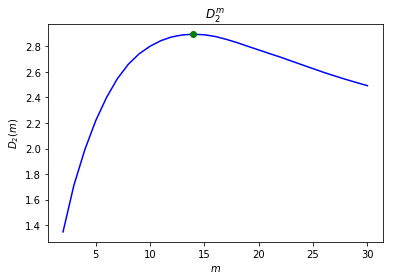

CHANNEL 1
tau=3


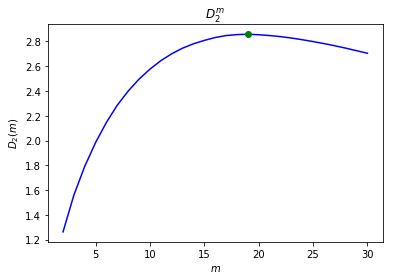

CHANNEL 2
tau=3


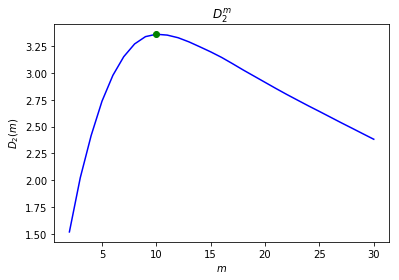

CHANNEL 3
tau=3


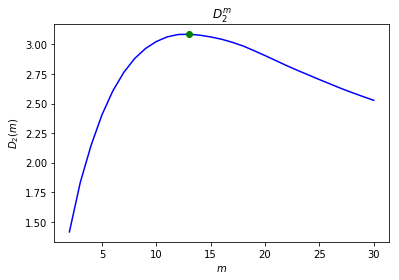

CHANNEL 4
tau=3


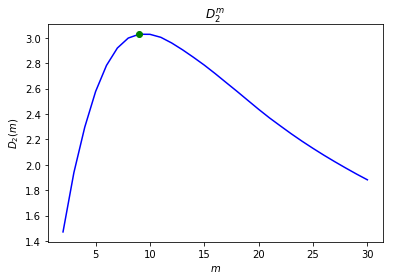

CHANNEL 5
tau=3


Process ForkPoolWorker-734:
Process ForkPoolWorker-741:
Process ForkPoolWorker-733:
Process ForkPoolWorker-740:
Process ForkPoolWorker-738:
Process ForkPoolWorker-736:
Process ForkPoolWorker-735:
Process ForkPoolWorker-739:
Process ForkPoolWorker-737:
Process ForkPoolWorker-743:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-742:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    s

KeyboardInterrupt: 

  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/utils.py", line 173, in neighbors
    valid = (np.abs(index - i) > window) & (dist > 0)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/d2.py", line 102, in c2
    dists = distance.cdist([y[i]], y[i + window + 1:], metric=metric)[0]
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._ar

In [17]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


for chan_num, chan_data in enumerate(eeg_signals):
    print(f'CHANNEL {chan_num}')
    for tau in np.arange(3, 4):
        print(f'tau={tau}')
        dim = np.arange(2, 30 + 1)

        rcs = d2.c2_embed(chan_data, tau=tau, dim=dim, window=50, metric='chebyshev', r=100)

        plt.figure(1)
        plt.title(f'$D_2^m$')
        plt.xlabel(r'$m$')
        plt.ylabel(r'$D_2(m)$')

        slopes = []
        for r, c in rcs:
            slopes.append(np.polyfit(np.log(r), np.log(c), 1)[0])
        # slopes = smooth(slopes, 2)
        # diffs = np.diff(slopes)
        # sums = np.asarray([np.abs(max(diffs[i-2:i+3]) - min(diffs[i-2:i+3])) for i in range(2,len(diffs)-3)])
        # i = np.argmin(sums)
        i = np.argmax(slopes)
        # plt.plot(dim, slopes, 'b-', dim[:-1], diffs, 'r-', dim[i], slopes[i], 'go')
        plt.plot(dim, slopes, 'b-', dim[i], slopes[i], 'go')
        plt.show()